In [1]:
%matplotlib inline
%config Completer.use_jedi = False # to use autocomplete
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
import json
import pandas as pd
import sklearn
from random import seed
from sklearn.model_selection import KFold
from sklearn import linear_model, ensemble, neighbors, tree
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from texttable import Texttable
import scipy.optimize as optimization
RANDOM_SEED=0
seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(sklearn.__version__)
from itertools import combinations
from numpy.random import default_rng
import itertools

0.24.2


In [2]:
def path_leaf(path): # get filename(with extension) from path
    head, tail = os.path.split(path)
    return tail or os.path.basename(head)


def file_in_folder(folder_path, flag=1): # get files in given folder, return list of filepath and filename
    file_list = []
    file_name = []
    for(dirpath, dirnames, filenames) in os.walk(folder_path):
#         print(filenames)
        
        for i in filenames:
            try:
                file_list += [dirpath + os.sep + i]
                file_name += [i]
            except:
                continue
        if flag == 0:
            break
        file_list.sort(key=path_leaf)
        file_name.sort()
    return [file_list, file_name]

In [3]:
res_dir = '../../prediction_code/mse_in_sample_transfer/in_sample'
all_folders = [os.path.join(res_dir, i) for i in os.listdir(res_dir)]

data_folder = '../../../data/PPP_normalized_44'
file_list, file_name = file_in_folder(data_folder)
file_list = [i for i in file_list if '.csv' in i]
file_name = [i for i in file_name if '.csv' in i]
num_name_dic = {i: name for i, name in enumerate(file_name)}
name_num_dic = {name: i for i, name in enumerate(file_name)}
print(num_name_dic, name_num_dic)

all_params = ['a', 'b', 'd', 'g']
CPT_models = []
for i in range(1, len(all_params)+1):
    tmp = list(itertools.combinations(all_params, i))
    CPT_models += tmp
    
CPT_models = [''.join(i) for i in CPT_models]
CPT_models = ['g', 'ab', 'dg', 'abg', 'abdg']
# model_types = [model_types[-1]]
print(CPT_models)
ML_models = ['DT', 'RF', 'NN']
ML_models = ['Lasso', 'RF', 'NN']
ML_models = ['EU_iso', 'RF', 'NN', 'kernel_ridge_rbf']

all_models = CPT_models + ML_models

{0: 'Australia_data_30countries.csv', 1: 'Belgium_data_30countries.csv', 2: 'Brazil_data_30countries.csv', 3: 'Cambodia_data_30countries.csv', 4: 'Chile_data_30countries.csv', 5: 'China_data_30countries.csv', 6: 'Colombia_data_30countries.csv', 7: 'Costa Rica_data_30countries.csv', 8: 'Czech Republic_data_30countries.csv', 9: 'Ethiopia_data_30countries.csv', 10: 'France_data_30countries.csv', 11: 'Germany_data_30countries.csv', 12: 'Guatemala_data_30countries.csv', 13: 'India_data_30countries.csv', 14: 'Japan_data_30countries.csv', 15: 'Kyrgyzstan_data_30countries.csv', 16: 'Malaysia_data_30countries.csv', 17: 'Monetary incentives in the loss domain.csv', 18: 'Nicaragua_data_30countries.csv', 19: 'Nigeria_data_30countries.csv', 20: 'Peru_data_30countries.csv', 21: 'Poland_data_30countries.csv', 22: 'Russia_data_30countries.csv', 23: 'Saudi Arabia_data_30countries.csv', 24: 'South Africa_data_30countries.csv', 25: 'Spain_data_30countries.csv', 26: 'Thailand_data_30countries.csv', 27: 'T

In [4]:
show_num_name_dic = {'num': [], 'name': []}
for key, val in num_name_dic.items():
    show_num_name_dic['num'].append(key)
    show_num_name_dic['name'].append(val)
num_name_df = pd.DataFrame.from_dict(show_num_name_dic)
# print(num_name_df.to_latex(index=False))
num_name_df



,num,name
0,0,Australia_data_30countries.csv
1,1,Belgium_data_30countries.csv
2,2,Brazil_data_30countries.csv
3,3,Cambodia_data_30countries.csv
4,4,Chile_data_30countries.csv
5,5,China_data_30countries.csv
6,6,Colombia_data_30countries.csv
7,7,Costa Rica_data_30countries.csv
8,8,Czech Republic_data_30countries.csv
9,9,Ethiopia_data_30countries.csv


In [5]:
def get_in_sample(folder='../../prediction_code/mse_in_sample_transfer/in_sample'):
    in_sample_folders = os.listdir(folder)
    res = {}
    for cur_fol in in_sample_folders:
        file_list, file_name = file_in_folder(os.path.join(folder, cur_fol))
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        for file in file_list:
            with open(file, 'r') as f:
                content = json.load(f)
#             print(content)
            if cur_fol not in res.keys():
                res[cur_fol] = {}
#             print(file)
#             if '/EU' in file:
#                 tmp = 'EU'
#             else:
            tmp = content['model_type']
            res[cur_fol][tmp] = content['train_mse']
    print(res)
    return res

In [6]:
in_sample_res = get_in_sample()

{'32': {'EU_expo': 98.05439546425342, 'EU_iso': 96.78211735028366, 'RF': 22.0382371098342, 'a': 96.45314988583107, 'ab': 96.45314988583108, 'abd': 80.50749887065983, 'abdg': 40.59413808576507, 'abg': 42.57730662751866, 'ad': 84.7525276032429, 'adg': 40.594138085760676, 'ag': 42.57730662751865, 'b': 98.05439546425342, 'bd': 97.65227409409118, 'bdg': 45.55436640438005, 'bg': 45.55612108761079, 'd': 97.65227409409117, 'dg': 45.55436640437995, 'g': 45.5561210876108, 'kernel_ridge_rbf': 22.1277134329341}, '35': {'EU_expo': 1.9725716349701312, 'EU_iso': 1.553385041791739, 'RF': 1.344576421686958, 'a': 1.3734339285488562, 'ab': 1.3734339285488562, 'abd': 1.3734339285488564, 'abdg': 1.3734339285488564, 'abg': 1.3734339285488562, 'ad': 1.373433928548856, 'adg': 1.3734339285488562, 'ag': 1.3734339285488562, 'b': 1.9725716349701312, 'bd': 1.3734339285488562, 'bdg': 1.3734339285488562, 'bg': 1.9725716349701312, 'd': 1.3734339285488564, 'dg': 1.3734339285488564, 'g': 1.9725716349701312, 'kernel_rid

In [7]:
in_sample_res['31']

{'EU_expo': 319676403.3705415,
 'EU_iso': 306687621.31341386,
 'RF': 223538973.9540428,
 'a': 298436111.7655749,
 'ab': 297999520.27154714,
 'abd': 291276841.036299,
 'abdg': 226492755.67801186,
 'abg': 226507403.92863357,
 'ad': 291276841.0362987,
 'adg': 226654993.74199992,
 'ag': 229674254.17012292,
 'b': 319239811.8765137,
 'bd': 293078915.0490764,
 'bdg': 233094070.01005057,
 'bg': 252506596.24761423,
 'd': 293078915.0490763,
 'dg': 233094070.01005054,
 'g': 255588006.62003183,
 'kernel_ridge_rbf': 228627145.0488663}

In [8]:
def get_round(a, digit=3):
    return round(a, digit)

def get_res(folder, normalize=False, in_sample_dic=None):
    file_list, file_name = file_in_folder(folder)
    file_list = [i for i in file_list if '.json' in i]
    file_name = [i for i in file_name if '.json' in i]
    print(file_list)
    res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    train_data = folder.split('/')[1]
    for model_type in all_models:
        for file in file_list:
            file_type = path_leaf(file).split('.json')[0]
            if model_type == file_type:
                with open(file, 'r') as f:
                    content = json.load(f)
#                 print(content)
                res_dic['model'].append(content['model_type'])
                res_dic['train_data'].append(train_data)
                res_dic['train_mse'].append(get_round(content['train_mse']))
                for key, val in content['test_mse'].items():
                    if key not in num_name_dic.keys():
                        continue
                    if key not in res_dic.keys():
                        res_dic[key] = []
                    if normalize:
                        res_dic[key].append(get_round(val/in_sample_dic[key][model_type]))
                    else:
                        res_dic[key].append(get_round(val))

#     print(res_dic)
    df = pd.DataFrame.from_dict(res_dic)
    display(df)
    print(df.to_latex(index=False))
    return res_dic

In [9]:
def get_index(arr, median_of):
    # median_of is 'min', 'max', or percentile (50, 75, 90, etc.)
    if median_of == 'max':
        return np.argmax(arr)
    elif median_of == 'min':
        return np.argmin(arr)
    else:
        percent = int(median_of)
        interpolation = 'higher'
        if percent < 50:
            interpolation = 'lower'
        val = np.percentile(arr, percent, interpolation=interpolation)
#         if val in arr:
#             print(1, val)
#         else:
#             print(0, val)
#             print(arr)
        return arr.index(val)

def get_median_transfer_error(folder_list, normalize=False, in_sample_dic=None, use_best_in_sample=False, median_of='max'):
    if use_best_in_sample:
        best_in_sample_across_model = {}
        for key, val in in_sample_dic.items():
            best_in_sample_across_model[key] = {}

            best_in_sample = 1e10
            for model_type, cur_error in val.items():
                if best_in_sample > cur_error:
                    best_in_sample = cur_error
            for model_type in val.keys():
                best_in_sample_across_model[key][model_type] = best_in_sample
    else:
        best_in_sample_across_model = in_sample_dic
    
        
#     print(best_in_sample_across_model)
#     res_dic = {'model': [], 'train_data': [], 'train_mse': []}
    res_dic = {}
    all_res_dic = {}
    for folder in folder_list:
        if path_leaf(folder) == '.DS_Store' or int(path_leaf(folder)) not in num_name_dic.keys():
            continue
        file_list, file_name = file_in_folder(folder)
        file_list = [i for i in file_list if '.json' in i]
        file_name = [i for i in file_name if '.json' in i]
#         print(file_list)
        
        train_data = folder.split('/')[1]
        for model_type in all_models:
            if model_type not in res_dic.keys():
                res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
                all_res_dic[model_type] = {'train_data': [], 'transfer_domain': [], 'in_sample': [], 
                                       'raw_transfer': [], 'best_in_sample': [], 'transfer_ratio': []}
            for file in file_list:
                file_type = path_leaf(file).split('.json')[0]
                if model_type == file_type:
                    with open(file, 'r') as f:
                        content = json.load(f)

                    all_transfer_domain = []
                    all_transfer_error_ratio = []
                    raw_transfer = []
                    in_sample = []
                    best_in_sample = []
                    for key, val in content['test_mse'].items():
                        if int(key) not in num_name_dic.keys():
                            continue
                        all_transfer_domain.append(key)
                        raw_transfer.append(get_round(np.sqrt(val)))
                        in_sample.append(get_round(np.sqrt(in_sample_dic[key][model_type])))
                        best_in_sample.append(get_round(np.sqrt(best_in_sample_across_model[key][model_type])))
#                         all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
                        all_transfer_error_ratio.append(get_round(np.sqrt(val)/np.sqrt(best_in_sample_across_model[key][model_type])))
#                         if normalize:
#                             all_transfer_error_ratio.append(get_round(best_in_sample_across_model[key][model_type]/val))
#                         else:
#                             all_transfer_error_ratio.append(get_round(val))
                    
#                     print(len(all_transfer_domain))
                    if normalize:
                        list_to_find_index = all_transfer_error_ratio
                    else:
                        list_to_find_index = raw_transfer
#                     best_idx = np.argmax(raw_transfer)
                    best_idx = get_index(list_to_find_index, median_of=median_of)
#                     print(best_idx)
                    res_dic[model_type]['train_data'].append(train_data)
                    res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio[best_idx])
                    res_dic[model_type]['transfer_domain'].append(all_transfer_domain[best_idx])
                    res_dic[model_type]['raw_transfer'].append(raw_transfer[best_idx])
                    res_dic[model_type]['in_sample'].append(in_sample[best_idx])
                    res_dic[model_type]['best_in_sample'].append(best_in_sample[best_idx])
                    
                    all_res_dic[model_type]['train_data'].append([train_data]*len(all_transfer_error_ratio))
                    all_res_dic[model_type]['transfer_ratio'].append(all_transfer_error_ratio)
                    all_res_dic[model_type]['transfer_domain'].append(all_transfer_domain)
                    all_res_dic[model_type]['raw_transfer'].append(raw_transfer)
                    all_res_dic[model_type]['in_sample'].append(in_sample)
                    all_res_dic[model_type]['best_in_sample'].append(best_in_sample)
#     print(res_dic)
    
    
#     if normalize:
#         sort_key = 'transfer_ratio'
#     else:
#         sort_key = 'raw_transfer'
#     final_res = {'model': [], 'train_data': [], 'transfer_domain': [], 'in_sample': [], 'raw_transfer': [], 
#                  'best_in_sample': [], 'transfer_ratio': []}
#     only_median_res = {'model': [], 'median_transfer_error': []}
#     for key, val in res_dic.items():
# #         print(key)
#         df = pd.DataFrame.from_dict(val)
# #         print(df.shape)
# #         display(df)
        
# #         only_median_res['model'].append(key)
# #         only_median_res['median_transfer_error'].append(df['raw_transfer'].median())
        
#         if df.shape[0] % 2 == 1:
# #             print(1)
# #             display(df.loc[df['transfer_error']==df['transfer_error'].median()])
#             tmp_rol = df.loc[df[sort_key]==df[sort_key].median()]
# #             display(tmp_rol)
#             final_res['model'].append(key)
#             final_res['train_data'].append(tmp_rol['train_data'])
#             final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
#             final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
#             final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
#             final_res['in_sample'].append(tmp_rol['in_sample'])
#             final_res['best_in_sample'].append(tmp_rol['best_in_sample'])
            
#         else:
# #             print(2)
#             tmp_df = df.sort_values(by=sort_key)
# #             if key == 'NN':
# #                 display(tmp_df)
# #             display(tmp_df[tmp_df['transfer_error'] < tmp_df['transfer_error'].median()].iloc[-1])
#             left_idx = (tmp_df.shape[0] - 1) // 2
#             right_idx = (tmp_df.shape[0] + 1) // 2
# #             display(tmp_df[tmp_df['transfer_error'] < tmp_df['transfer_error'].median()].iloc[-1])
# #             tmp_rol = tmp_df[tmp_df['transfer_ratio'] < tmp_df['transfer_ratio'].median()].iloc[-1]

# #             tmp_rol = tmp_df.iloc[left_idx]
# #             final_res['model'].append(key)
# #             final_res['train_data'].append(tmp_rol['train_data'])
# #             final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
# #             final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
# #             final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
# #             final_res['in_sample'].append(tmp_rol['in_sample'])
# #             final_res['best_in_sample'].append(tmp_rol['best_in_sample'])
            
# #             display(tmp_df[tmp_df['transfer_error'] > tmp_df['transfer_error'].median()].iloc[0])
# #             tmp_rol = tmp_df[tmp_df['transfer_ratio'] > tmp_df['transfer_ratio'].median()].iloc[0]
#             tmp_rol = tmp_df.iloc[right_idx]
#             final_res['model'].append(key)
#             final_res['train_data'].append(tmp_rol['train_data'])
#             final_res['transfer_domain'].append(tmp_rol['transfer_domain'])
#             final_res['transfer_ratio'].append(tmp_rol['transfer_ratio'])
#             final_res['raw_transfer'].append(tmp_rol['raw_transfer'])
#             final_res['in_sample'].append(tmp_rol['in_sample'])
#             final_res['best_in_sample'].append(tmp_rol['best_in_sample'])
            
            
# #     print(final_res)
#     df = pd.DataFrame.from_dict(final_res)
#     display(df)
#     print(df.to_latex(index=False))
    
#     print(only_median_res)
#     df = pd.DataFrame.from_dict(only_median_res)
#     display(df)
#     print(df.to_latex(index=False))
    return all_res_dic

In [10]:
median_of_list = ['max', 90, 75, 50, 25, 10, 'min']
all_res_raw_transfer = {}
for median_of in median_of_list:
    print(median_of)
    all_res_raw_transfer[median_of] = get_median_transfer_error(all_folders, normalize=False, in_sample_dic=in_sample_res, use_best_in_sample=False, median_of=median_of)
    print()

max

90

75

50

25

10

min



In [11]:
median_of_list = ['max', 90, 75, 50, 25, 10, 'min']
all_res_normalize_by_best = {}
for median_of in median_of_list:
    print(median_of)
    all_res_normalize_by_best[median_of] = get_median_transfer_error(all_folders, normalize=True, in_sample_dic=in_sample_res, use_best_in_sample=True, median_of=median_of)
    print()

max

90

75

50

25

10

min



In [12]:
median_of_list = ['max', 90, 75, 50, 25, 10, 'min']
all_res_normalize_by_same = {}
for median_of in median_of_list:
    print(median_of)
    all_res_normalize_by_same[median_of] = get_median_transfer_error(all_folders, normalize=True, in_sample_dic=in_sample_res, use_best_in_sample=False, median_of=median_of)
    print()

max

90

75

50

25

10

min



In [13]:
def draw_plot(all_res, target='transfer_ratio', semiy=False, plot_range=[0,1], 
              models=['abdg', 'EU_iso', 'RF', 'kernel_ridge_rbf'], y_label=None, save_path=None, separate_ML_CPT=False):
    name_dic = {'g': r'$\gamma$', 'ab': r'$\alpha\beta$', 'dg': r'$\delta\gamma$', 
           'abg': r'$\alpha\beta\gamma$', 'abdg': r'$\alpha\beta\delta\gamma$', 
           'RF': 'RF', 'NN': 'NN', 'Random Forest': 'RF', 'Neural Net': 'NN'
          }
    name_dic = {'g': r'$\gamma$', 'ab': r'$\alpha\beta$', 'dg': r'$\delta\gamma$', 
           'abg': r'$\alpha\beta\gamma$', 'abdg': r'$\alpha\beta\delta\gamma$', 
           'RF': 'RF', 'NN': 'NN', 'Random Forest': 'RF', 'Neural Net': 'NN', 
           'kernel_ridge_poly': 'OLS-poly', 'kernel_ridge_rbf': 'KR', 'EU_expo': 'EU-CARA', 'EU_iso': 'EU'
          }
    CPT_count = 0
    ML_count = 0
    CPT_color = '#1f77b4'
    ML_colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    abdg_res = None
    RF_res = None
    for model in models:
        datas = all_res['max'][model]
    #     print(len(datas['transfer_ratio'][0]))
        sort_ratio = []
        for i in datas[target]:
            sort_ratio.append(sorted(i))
#         if model == 'NN':
#             print(sort_ratio, len(sort_ratio))
        sort_ratio = np.array(sort_ratio)
        final_y = np.sort(sort_ratio, axis=None)
#         final_y = np.median(sort_ratio, axis=0)
#         print(final_y.shape)
        length = final_y.shape[0]
        x = np.array(list(range(length))) / length * 100
        final_y = final_y[int(np.floor(length*plot_range[0])):int(np.ceil(length*plot_range[1]))]
        x = x[int(np.floor(length*plot_range[0])):int(np.ceil(length*plot_range[1]))]
#         print(x)
        if model == 'abdg':
            abdg_res = final_y
        elif model == 'RF':
            RF_res = final_y
        else:
            pass
        if not semiy:
            if separate_ML_CPT:
                if model in CPT_models:
                    color = CPT_color
                    if CPT_count == 0:
                        plt.plot(x, final_y, label='CPT', color=color)
                        CPT_count += 1
                    else:
                        plt.plot(x, final_y, color=color)
                else:
                    color = ML_colors[ML_count]
                    if model == 'RF':
                        cur_model = 'Random Forest'
                    elif model == 'NN':
                        cur_model = 'Neural Net'
                    else:
                        cur_model = model
                    cur_model = name_dic[cur_model]
                    plt.plot(x, final_y, label=cur_model, color=color)
                    ML_count += 1
#                     if ML_count == 0:
#                         ML_count += 1
#                         plt.plot(x, final_y, label=model, color=color)
#                     else:
#                         plt.plot(x, final_y, color=color)
            else:
                plt.plot(x, final_y, label=name_dic[model])
        else:
            if separate_ML_CPT:
                if model in CPT_models:
                    color = CPT_color
                    if CPT_count == 0:
                        plt.semilogy(x, final_y, label='CPT', color=color)
                        CPT_count += 1
                    else:
                        plt.semilogy(x, final_y, color=color)
                else:
                    color = ML_colors[ML_count]
                    if model == 'RF':
                        cur_model = 'Random Forest'
                    elif model == 'NN':
                        cur_model = 'Neural Net'
                    else:
                        cur_model = model
                    cur_model = name_dic[cur_model]
                    plt.semilogy(x, final_y, label=cur_model, color=color)
                    ML_count += 1
#                     if ML_count == 0:
#                         ML_count += 1
#                         plt.semilogy(x, final_y, label=model, color=color)
#                     else:
#                         plt.semilogy(x, final_y, color=color)
                
            else:
                plt.semilogy(x, final_y, label=name_dic[model])
    plt.legend()
    plt.xlabel('Percentile')
    if y_label is None:
        plt.ylabel(f'{target}')
    else:
        plt.ylabel(f'{y_label}')
    if plot_range[0] == 0.05:
        plt.xticks([5+i*10 for i in range(10)])
#     plt.title(title)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    tmp = abdg_res/RF_res
#     for i in tmp:
#         if i > 1:
#             print(i)
#     print(final_y, final_y.shape)

# 5-95 percentile

In [15]:
plt.rcdefaults()
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'font.family':'Times New Roman'})
plt.rc('text', usetex=True)
lower_percent = 5
higher_percent = 95
transfer_error = 'Raw transfer error'
normalized_transfer = 'Transfer shortfall'
same_model_transfer = 'Transfer deterioration'
# fol = '../stack_figures/to_stack'
fol = '.'

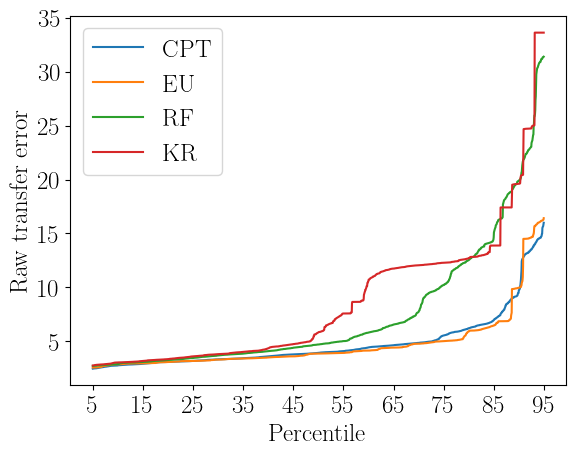

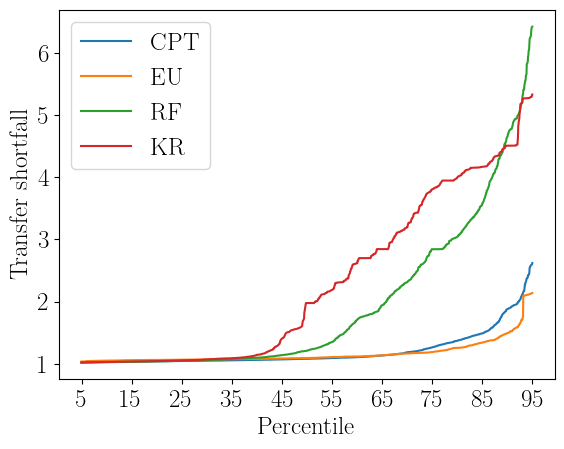

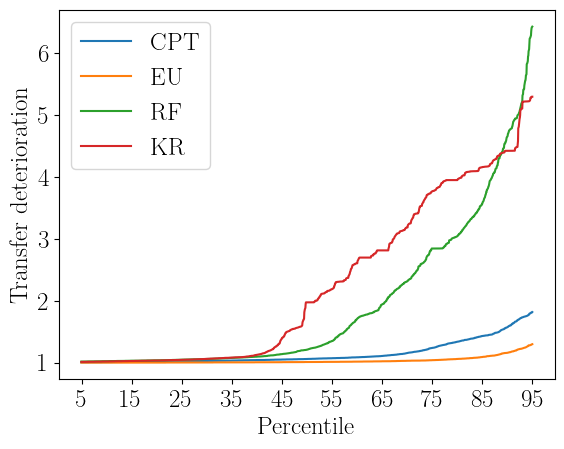

In [16]:
# draw_plot(all_res_raw_transfer, target='raw_transfer', y_label=transfer_error, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_transfer_error.pdf', plot_range=[lower_percent/100,(higher_percent)/100])
# draw_plot(all_res_normalize_by_best, target='transfer_ratio', y_label=normalized_transfer, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_normalized_transfer_error.pdf', plot_range=[lower_percent/100,(higher_percent)/100])
# draw_plot(all_res_normalize_by_same, target='transfer_ratio', y_label=same_model_transfer, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_transfer_deterioration.pdf', plot_range=[lower_percent/100,(higher_percent)/100])

draw_plot(all_res_raw_transfer, target='raw_transfer', y_label=transfer_error, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_separate_transfer_error.pdf', plot_range=[lower_percent/100,(higher_percent)/100], separate_ML_CPT=True)
draw_plot(all_res_normalize_by_best, target='transfer_ratio', y_label=normalized_transfer, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_separate_normalized_transfer_error.pdf', plot_range=[lower_percent/100,(higher_percent)/100], separate_ML_CPT=True)
draw_plot(all_res_normalize_by_same, target='transfer_ratio', y_label=same_model_transfer, semiy=False, save_path=f'{fol}/{lower_percent}_{higher_percent}_separate_transfer_deterioration.pdf', plot_range=[lower_percent/100,(higher_percent)/100], separate_ML_CPT=True)